In [1]:
# This notebook aims to cluster topics in CORD-19 DB
# by implementing LDA Algortihm, this will help to reduce
# the number of instances to focus in the database.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# This libraries will help on the preprocessing
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.porter import *
np.random.seed(400)

In [4]:
# Here the topic with the maximum distribution is returned
def max_topic(dist):
    maximum = 0
    topic = None
    for t in lda_model[dist]:
        if t[1] > maximum:
            maximum = t[1]
            topic = t[0]
    return topic

In [5]:
# Tokenize, stem and removing stopwords
stemmer = PorterStemmer()
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(stemmer.stem(token))
    return result

In [6]:
# Function that compares a string with a given list
def contains_covid(title):
    lst = ["covid", "covid-19", "ncov", "sars-cov-2", "novel coronavirus", "coronavirus", "sarscov2", "corona"]
    for x in lst:
        title = str(title)
        if x in title.lower():
            return title
    return np.nan

In [7]:
current_location = 'CORD-19-research-challenge/'
filename = 'CORD-19-research-challenge/metadata.csv'

In [8]:
# Reading the db metadata
cord_db = pd.read_csv(filename, skipinitialspace=True)
print(cord_db.shape)
cord_db.head()

(59887, 19)


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998.0,unk,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704.0,unk,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125.0,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,2sfqsfm1,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723.0,unk,The key enzyme in coronavirus polyprotein proc...,2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc126080?pdf=re...
4,i0zym7iq,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663.0,unk,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc136939?pdf=re...


In [9]:
# Make sure there is not NaN values
cord_db = cord_db.dropna(subset=['sha', 'abstract','publish_time','title'])
print(cord_db.shape)

(39676, 19)


In [10]:
# Eliminate publications before 2019
cord_db['publish_time'] = cord_db['publish_time'].apply(lambda x: str(x)[0:4])
cord_db19 = cord_db[cord_db.publish_time == '2019']
cord_db20 = cord_db[cord_db.publish_time == '2020']
cord_db19.append(cord_db20)
cord_db = cord_db19
print(cord_db.shape)
cord_db.head()

(3290, 19)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
10173,gcj14snd,1d05dbf38f98918269d71020f0c9ff616548c2df,PMC,Human rhinovirus spatial-temporal epidemiology...,10.12688/wellcomeopenres.14836.2,PMC6234744,30483602.0,cc-by,Background: Human rhinovirus (HRV) is the pred...,2019,"Morobe, John Mwita; Nyiro, Joyce U.; Brand, Sa...",Wellcome Open Res,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...
10395,stu49tf5,584aa286fb6e7f2404ff67c5cfa025b33e110214,PMC,"Epidemiology of Imported Infectious Diseases, ...",10.3201/eid2501.180178,PMC6302593,30560778.0,no-cc,Imported infectious diseases are becoming a se...,2019,"Wang, Yali; Wang, Xuan; Liu, Xiaobo; Ren, Ruiq...",Emerg Infect Dis,NaN,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...
10396,qlwzl5mq,4c7f6c52fe043745887db5406196b1d5099c9614,PMC,Multiple Introductions of Domestic Cat Feline ...,10.3201/eid2501.181347,PMC6302599,30561312.0,no-cc,The endangered Florida panther (Puma concolor ...,2019,"Chiu, Elliott S.; Kraberger, Simona; Cunningha...",Emerg Infect Dis,NaN,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...
10434,eqgc8v7y,e5c06914d0daee6e881665b23adca340d0a6271a,PMC,Impact of glucose-6-phosphate dehydrogenase de...,10.1371/journal.pone.0209204,PMC6314580,30601843.0,cc-by,Glucose-6-phosphate dehydrogenase (G6PD) defic...,2019,"May, Win Lai; Kyaw, Myat Phone; Blacksell, Stu...",PLoS One,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...
10463,hbpk850a,ca8f30a35b564945dd2588c382a0e181a1e08662,PMC,Mental health workers perceptions of disaster ...,10.1186/s12889-018-6313-9,PMC6318987,30606149.0,cc-by,BACKGROUND: The post-disaster mental health cr...,2019,"Xi, Yingjun; Chen, Runsen; Gillespie, Amy L.; ...",BMC Public Health,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...


In [11]:
# Maintain publications containing in title "COVID" OR "COVID-19" OR “2019- nCoV” OR “SARS-CoV-2” OR “Novel coronavirus”
cord_db["title"] = cord_db["title"].apply(contains_covid)
cord_db = cord_db.dropna(subset=['title'])
print(cord_db.shape)
cord_db.head()

(265, 19)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
10514,56fyy9mn,dedff395d93d8023667fc500d7c7c8451d581451,PMC,Antiviral activity of itraconazole against typ...,10.1186/s13567-019-0625-3,PMC6339390,30658691.0,cc-by,Feline coronaviruses (FCoVs) are the causative...,2019,"Takano, Tomomi; Akiyama, Misuzu; Doki, Tomoyos...",Vet Res,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...
10569,wmi583s4,cd4c984e7afa08f850f9173578fbae31d92a64a5,PMC,Genetic Diversity and Phylodynamics of Avian C...,10.3390/v11010057,PMC6356246,30646528.0,cc-by,Avian coronaviruses (ACoVs) are continuously e...,2019,"A. Rohaim, Mohammed; F. El Naggar, Rania; M. H...",Viruses,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...
10572,tjp33y35,697cf5b78c388d6e79a7a87ac9b82e4911de135a,PMC,Development of a Whole-Virus ELISA for Serolog...,10.3390/v11010043,PMC6356407,30634419.0,cc-by,Known human coronaviruses are believed to have...,2019,"El-Duah, Philip; Meyer, Benjamin; Sylverken, A...",Viruses,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...
10573,olmein3q,19babdefd145a5becbc2a0b189eabdafa697de75,PMC,Bats and Coronaviruses,10.3390/v11010041,PMC6356540,30634396.0,cc-by,Bats are speculated to be reservoirs of severa...,2019,"Banerjee, Arinjay; Kulcsar, Kirsten; Misra, Vi...",Viruses,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...
10585,2mamwrfq,e68b0f3da8a02a8f0b86869e533eaf549f70ff9a,PMC,Potent MERS-CoV Fusion Inhibitory Peptides Ide...,10.3390/v11010056,PMC6357153,30646495.0,cc-by,The Middle East respiratory syndrome coronavir...,2019,"Xia, Shuai; Lan, Qiaoshuai; Pu, Jing; Wang, Co...",Viruses,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...


In [12]:
# Once the dataset is reduced this cell is focus on preprocessing
processed_docs = []

for doc in cord_db['abstract']:
    processed_docs.append(preprocess(doc))

In [13]:
# Create a dictionary from 'processed_docs' containing the number of times a word appears 
# in the training set using gensim.corpora.Dictionary
dictionary = gensim.corpora.Dictionary(processed_docs)

In [14]:
# Remove very rare and very common words:
# words appearing less than 15 times
# words appearing in more than 10% of all documents
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [15]:
# Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
# words and how many times those words appear. Save this to 'bow_corpus'
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [16]:
# Here the aim is to find the best parameters by evaluating its coherence with UMass score
max_model = None
max_n = 2
max_coherence = 0
coherence_values = []
for n in range(2, 14, 2):
    model = gensim.models.LdaMulticore(corpus = bow_corpus, num_topics = n, id2word = dictionary, passes = 10)
    coherence_model = gensim.models.CoherenceModel(model = model, texts = processed_docs, dictionary = dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    if coherence_score > max_coherence:
        max_coherence = coherence_score
        max_model = model
        max_n = n
    coherence_values.append(coherence_score)

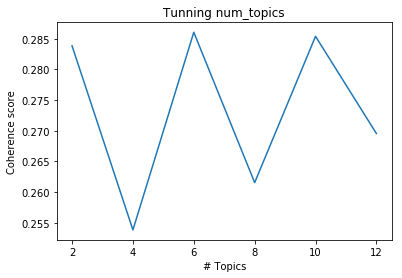

In [17]:
x = range(2, 14, 2)
plt.plot(x, coherence_values)
plt.xlabel("# Topics")
plt.ylabel("Coherence score")
plt.title("Tunning num_topics")
plt.show()

In [18]:
# Running LDA Using bag of words
# Using number of topics found in the coherence score
lda_model = max_model

In [19]:
coherence_model = gensim.models.CoherenceModel(model = lda_model, texts = processed_docs, dictionary = dictionary, coherence='c_v')
print("Coherence score: %d \n", coherence_model.get_coherence())

Coherence score: %d 
 0.28605378510348994


In [20]:
# Explore the words occuring for each topic and its relative weight
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.059*"mice" + 0.043*"membran" + 0.033*"inhibit" + 0.031*"lung" + 0.030*"fusion" + 0.027*"pathogenesi" + 0.023*"vitro" + 0.022*"domain" + 0.021*"cellular" + 0.021*"neutral"


Topic: 1 
Words: 0.070*"revers" + 0.056*"felin" + 0.044*"virul" + 0.037*"attenu" + 0.036*"real" + 0.031*"mutant" + 0.028*"transcript" + 0.026*"conserv" + 0.021*"previous" + 0.020*"antigen"


Topic: 2 
Words: 0.065*"innat" + 0.058*"pathway" + 0.051*"signal" + 0.039*"knowledg" + 0.027*"agent" + 0.027*"regul" + 0.027*"research" + 0.019*"interferon" + 0.019*"natur" + 0.018*"evolut"


Topic: 3 
Words: 0.122*"hcov" + 0.048*"neg" + 0.040*"entri" + 0.039*"screen" + 0.031*"hospit" + 0.026*"known" + 0.022*"depend" + 0.022*"challeng" + 0.021*"swab" + 0.021*"rang"


Topic: 4 
Words: 0.032*"china" + 0.030*"arabia" + 0.029*"circul" + 0.028*"hospit" + 0.026*"contact" + 0.022*"laboratori" + 0.021*"measur" + 0.020*"popul" + 0.020*"shed" + 0.019*"event"


Topic: 5 
Words: 0.051*"hcov" + 0.045*"materi" + 0.034*"drug

In [21]:
# The distribution of each of the trained documents to tbe given topics
lda_model[bow_corpus[0]]

[(0, 0.016908083),
 (1, 0.25202325),
 (2, 0.68082917),
 (3, 0.016792312),
 (4, 0.016705839),
 (5, 0.016741343)]

In [22]:
# Here is given the topics assigned to each document
topic_list = []
for i in range(0,len(cord_db)):
    topic_list.append(max_topic(bow_corpus[i]))
# Now lets add it to the dataframe
cord_db.insert (19, "topic", topic_list)
cord_db.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,topic
10514,56fyy9mn,dedff395d93d8023667fc500d7c7c8451d581451,PMC,Antiviral activity of itraconazole against typ...,10.1186/s13567-019-0625-3,PMC6339390,30658691.0,cc-by,Feline coronaviruses (FCoVs) are the causative...,2019,"Takano, Tomomi; Akiyama, Misuzu; Doki, Tomoyos...",Vet Res,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2
10569,wmi583s4,cd4c984e7afa08f850f9173578fbae31d92a64a5,PMC,Genetic Diversity and Phylodynamics of Avian C...,10.3390/v11010057,PMC6356246,30646528.0,cc-by,Avian coronaviruses (ACoVs) are continuously e...,2019,"A. Rohaim, Mohammed; F. El Naggar, Rania; M. H...",Viruses,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,0
10572,tjp33y35,697cf5b78c388d6e79a7a87ac9b82e4911de135a,PMC,Development of a Whole-Virus ELISA for Serolog...,10.3390/v11010043,PMC6356407,30634419.0,cc-by,Known human coronaviruses are believed to have...,2019,"El-Duah, Philip; Meyer, Benjamin; Sylverken, A...",Viruses,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,3
10573,olmein3q,19babdefd145a5becbc2a0b189eabdafa697de75,PMC,Bats and Coronaviruses,10.3390/v11010041,PMC6356540,30634396.0,cc-by,Bats are speculated to be reservoirs of severa...,2019,"Banerjee, Arinjay; Kulcsar, Kirsten; Misra, Vi...",Viruses,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2
10585,2mamwrfq,e68b0f3da8a02a8f0b86869e533eaf549f70ff9a,PMC,Potent MERS-CoV Fusion Inhibitory Peptides Ide...,10.3390/v11010056,PMC6357153,30646495.0,cc-by,The Middle East respiratory syndrome coronavir...,2019,"Xia, Shuai; Lan, Qiaoshuai; Pu, Jing; Wang, Co...",Viruses,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2


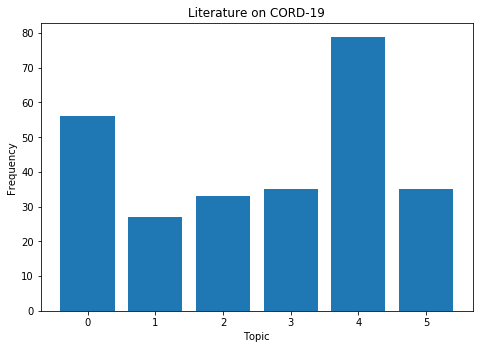

In [23]:
# Representation of topic frequency
freq_list = []
for i in range(0,max_n):
    freq_list.append(topic_list.count(i))
# Plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
topics = list(range(0, max_n))
ax.bar(topics,freq_list)
ax.set_ylabel('Frequency')
ax.set_xlabel('Topic')
ax.set_title('Literature on CORD-19')
plt.show()

In [24]:
print(freq_list)

[56, 27, 33, 35, 79, 35]


In [25]:
# Some visualization using Python library for interactive topic model visualization
import pyLDAvis
import pyLDAvis.gensim
for_viz = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(for_viz)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [26]:
# Once the topics are clustered, now papers will be label as threatments or vaccines
# based on frequency of words appearing on ontology dictionaries

In [27]:
# Explore the words occuring for each topic and its relative weight
#for idx, topic in lda_model.print_topics(-1):
#    print("Topic: {} \nWords: {}".format(idx, topic))
#    #print(type(topic))
#    #print(len(topic))
#    print("")
x = lda_model.show_topics(num_topics = 8, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
print('Topics and their respective words:')
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))
    #for i in words:
    #    print(i)
#print()

#Below Code Prints Only Words 
#for topic,words in topics_words:
#    print(" ".join(words))

Topics and their respective words:
0::['mice', 'membran', 'inhibit', 'lung', 'fusion', 'pathogenesi', 'vitro', 'domain', 'cellular', 'neutral']
1::['revers', 'felin', 'virul', 'attenu', 'real', 'mutant', 'transcript', 'conserv', 'previous', 'antigen']
2::['innat', 'pathway', 'signal', 'knowledg', 'agent', 'regul', 'research', 'interferon', 'natur', 'evolut']
3::['hcov', 'neg', 'entri', 'screen', 'hospit', 'known', 'depend', 'challeng', 'swab', 'rang']
4::['china', 'arabia', 'circul', 'hospit', 'contact', 'laboratori', 'measur', 'popul', 'shed', 'event']
5::['hcov', 'materi', 'drug', 'articl', 'electron', 'diagnosi', 'amino', 'tissu', 'diagnost', 'obtain']


In [28]:
# Every topic for every document
print('Every topic for every document:')
for i in cord_db['topic']:
    print(i)

Every topic for every document:
2
0
3
2
2
4
3
2
3
3
3
2
4
0
0
5
1
2
4
1
2
0
4
5
5
4
2
2
4
0
3
0
5
5
5
2
4
2
4
0
4
2
4
5
5
4
5
4
4
0
3
4
2
0
0
4
4
1
3
2
3
4
0
4
3
4
0
1
0
5
4
3
0
5
0
0
3
0
3
3
0
4
0
4
0
4
4
1
5
5
0
1
1
4
4
2
2
2
5
4
0
5
5
4
1
1
4
4
1
0
2
1
4
4
4
4
5
3
1
0
4
0
0
0
2
4
3
4
0
3
5
0
4
5
3
0
0
0
4
4
3
2
3
5
4
1
4
5
5
5
1
0
5
2
5
2
4
4
3
0
4
4
4
3
3
0
0
0
4
4
5
0
0
2
1
4
4
0
2
5
3
4
4
3
0
0
4
5
1
0
4
4
4
0
4
1
2
0
0
0
0
1
0
4
1
3
0
2
3
4
4
3
5
4
1
0
1
4
4
5
3
1
1
3
2
4
0
4
1
4
4
2
2
3
5
1
1
5
0
0
4
2
4
4
3
0
4
5
3
4
2
2
5
4
4
4
3
3
4
1
4
2
0
5
4


In [29]:
print('Every possible word in a dictionary:')
print(dictionary)

Every possible word in a dictionary:
Dictionary(161 unique tokens: ['agent', 'exhibit', 'felin', 'inhibit', 'system']...)


In [30]:
# Vaccines
# Therapeutics
with open('CORD-19-research-challenge/vaccines.txt', 'r') as f:
    x = f.readlines()
with open('CORD-19-research-challenge/drugs.txt', 'r') as f:
    y = f.readlines()
print('Vaccines listerm loaded')
print('Therapeutics listerm loaded')

Vaccines listerm loaded
Therapeutics listerm loaded


In [31]:
x = [strelement.strip() for strelement in x]
y = [strelement.strip() for strelement in y]

x = [strelement.lower() for strelement in x]
y = [strelement.lower() for strelement in y]

print('Vaccines listerm:')
print(str(len(x)) + ' words')
print(x)
print('')
print('Therapeutics listerm:')
print(str(len(y)) + ' words')
print(y)

Vaccines listerm:
121 words
['acellular vaccine', 'acquired immune deficiency syndrome', 'active immunity', 'acute', 'adjuvant', 'adverse events', 'allergy', 'anaphylaxis', 'anthrax', 'antibiotic', 'antibody', 'antigens', 'antitoxin', 'antiviral', 'arthralgia', 'arthritis', 'association', 'asthma', 'asymptomatic infection', 'autism', 'b cells', 'bias', 'biological plausibility', 'bone marrow', 'booster shots', 'brachial neuritis', 'breakthrough infection', 'combination vaccine', 'communicable', 'crohn’s disease', 'conjugate vaccine', 'contraindication', 'convulsion', 'crib or cot death', 'deltoid', 'diabetes', 'diphtheria', 'disease', 'efficacy rate', 'encephalitis', 'encephalopathy', 'epidemic', 'endemic', 'erythema multiforme', 'etiology', 'exposure', 'febrile', 'herd immunity', 'hives', 'hypersensitivity', 'hyposensitivity', 'immune globulin', 'immune system', 'immunity', 'immunization', 'immunosupression', 'inactivated vaccine', 'inapparent infection', 'incidence', 'incubation peri

In [32]:
#vaccineCounter = 0
#drugsCounter = 0

topicClassification = []

for topic,words in topics_words:
    print(str(topic))
    vaccineCounter = 0
    drugsCounter = 0
    for word in words:
        print(str(word))
        if word in x:
            #print(word)
            vaccineCounter += 1
        if word in y:
            #print(word)
            drugsCounter += 1
    
    print('-> ' + str(vaccineCounter))
    print('-> ' + str(drugsCounter))
    
    
    
    if vaccineCounter > drugsCounter:
        topicClassification.append('Vaccine')
        #cord_db.insert (20, 'topic classification', 'Vaccine')
    elif vaccineCounter < drugsCounter:
        topicClassification.append('Therapeutic')
        #cord_db.insert (20, 'topic classification', 'Therapeutic')
    elif vaccineCounter == 0 and drugsCounter == 0:
        topicClassification.append('None')
        #cord_db.insert (20, 'topic classification', 'None')
    elif vaccineCounter == drugsCounter:
        topicClassification.append('Tie')
        #cord_db.insert (20, 'topic classification', 'None')
        
    # cord_db.insert (20, "topic classification", )
    #cord_db.insert (21, 'topic vaccine counter', vaccineCounter)
    #cord_db.insert (22, 'topic therapeutic counter', drugsCounter)

print(topicClassification)

documentClassification = []

for i in cord_db['topic']:
    if i == 0:
        documentClassification.append(topicClassification[0])
        #temporal = topicClassification[0]
    elif i == 1:
        documentClassification.append(topicClassification[1])
        #temporal = topicClassification[1]
    elif i == 2:
        documentClassification.append(topicClassification[2])
        #temporal = topicClassification[2]
    elif i == 3:
        documentClassification.append(topicClassification[3])
        #temporal = topicClassification[3]
    elif i == 4:
        documentClassification.append(topicClassification[4])
        #temporal = topicClassification[4]
    elif i == 5:
        documentClassification.append(topicClassification[5])
        #temporal = topicClassification[5]
    elif i == 6:
        documentClassification.append(topicClassification[6])
        #temporal = topicClassification[6]
    elif i == 7:
        documentClassification.append(topicClassification[7])
        #temporal = topicClassification[7]

cord_db.insert(20, 'topic_classification', documentClassification)

print(len(documentClassification))        
print(documentClassification)

#print(vaccineCounter)
#print(drugsCounter)

cord_db.head()

0
mice
membran
inhibit
lung
fusion
pathogenesi
vitro
domain
cellular
neutral
-> 0
-> 0
1
revers
felin
virul
attenu
real
mutant
transcript
conserv
previous
antigen
-> 0
-> 0
2
innat
pathway
signal
knowledg
agent
regul
research
interferon
natur
evolut
-> 0
-> 0
3
hcov
neg
entri
screen
hospit
known
depend
challeng
swab
rang
-> 0
-> 0
4
china
arabia
circul
hospit
contact
laboratori
measur
popul
shed
event
-> 0
-> 0
5
hcov
materi
drug
articl
electron
diagnosi
amino
tissu
diagnost
obtain
-> 0
-> 1
['None', 'None', 'None', 'None', 'None', 'Therapeutic']
265
['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'Therapeutic', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'Therapeutic', 'Therapeutic', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'Therapeutic', 'Therapeutic', 'None', 'Therapeutic', 'No

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,journal,Microsoft Academic Paper ID,WHO #Covidence,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,topic,topic_classification
10514,56fyy9mn,dedff395d93d8023667fc500d7c7c8451d581451,PMC,Antiviral activity of itraconazole against typ...,10.1186/s13567-019-0625-3,PMC6339390,30658691.0,cc-by,Feline coronaviruses (FCoVs) are the causative...,2019,...,Vet Res,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2,None
10569,wmi583s4,cd4c984e7afa08f850f9173578fbae31d92a64a5,PMC,Genetic Diversity and Phylodynamics of Avian C...,10.3390/v11010057,PMC6356246,30646528.0,cc-by,Avian coronaviruses (ACoVs) are continuously e...,2019,...,Viruses,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,0,None
10572,tjp33y35,697cf5b78c388d6e79a7a87ac9b82e4911de135a,PMC,Development of a Whole-Virus ELISA for Serolog...,10.3390/v11010043,PMC6356407,30634419.0,cc-by,Known human coronaviruses are believed to have...,2019,...,Viruses,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,3,None
10573,olmein3q,19babdefd145a5becbc2a0b189eabdafa697de75,PMC,Bats and Coronaviruses,10.3390/v11010041,PMC6356540,30634396.0,cc-by,Bats are speculated to be reservoirs of severa...,2019,...,Viruses,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2,None
10585,2mamwrfq,e68b0f3da8a02a8f0b86869e533eaf549f70ff9a,PMC,Potent MERS-CoV Fusion Inhibitory Peptides Ide...,10.3390/v11010056,PMC6357153,30646495.0,cc-by,The Middle East respiratory syndrome coronavir...,2019,...,Viruses,NaN,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2,None


In [33]:
absctractsClassification = []
abstractVaccinesCounter = []
abstractDrugsCounter = []
for i in cord_db['abstract']:
    temporal = i.split()
    #print(temporal)
    temporal = [strelement.lower() for strelement in temporal]
    #print(temporal)
    vaccineCounter = 0
    drugsCounter = 0
    for word in temporal:
        if word in x:
            vaccineCounter += 1
        if word in y:
            drugsCounter += 1
    # print('-> ' + str(vaccineCounter))
    # print('-> ' + str(drugsCounter))
    
    abstractVaccinesCounter.append(vaccineCounter)
    abstractDrugsCounter.append(drugsCounter)
    
    if vaccineCounter > drugsCounter:
        absctractsClassification.append('Vaccine')
    elif vaccineCounter < drugsCounter:
        absctractsClassification.append('Therapeutic')
    elif vaccineCounter == 0 and drugsCounter == 0:
        absctractsClassification.append('None')
    elif vaccineCounter == drugsCounter:
        absctractsClassification.append('Tie')
print(len(absctractsClassification))
print(absctractsClassification)

cord_db.insert (21, 'abstract_classification', absctractsClassification)
cord_db.insert (22, 'abstract_vaccines_counter', abstractVaccinesCounter)
cord_db.insert (23, 'abstract_drugs_counter', abstractDrugsCounter)

265
['Vaccine', 'Vaccine', 'Therapeutic', 'Vaccine', 'Therapeutic', 'Vaccine', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Tie', 'Therapeutic', 'Therapeutic', 'Vaccine', 'Vaccine', 'Therapeutic', 'Vaccine', 'Therapeutic', 'Therapeutic', 'Vaccine', 'Tie', 'Therapeutic', 'Vaccine', 'Vaccine', 'Vaccine', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Tie', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Vaccine', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Tie', 'Therapeutic', 'Vaccine', 'Therapeutic', 'Vaccine', 'Therapeutic', 'Therapeutic', 'Vaccine', 'Vaccine', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Vaccine', 'Vaccine', 'Vaccine', 'Vaccine', 'Vaccine', 'Vaccine', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Vaccine', 'Tie', 'Vaccine', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Therapeutic', 'Tie', 'Therapeutic', 'Therapeutic', 'Vaccine', 'Therapeutic', 'Th

In [34]:
cord_db.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,topic,topic_classification,abstract_classification,abstract_vaccines_counter,abstract_drugs_counter
10514,56fyy9mn,dedff395d93d8023667fc500d7c7c8451d581451,PMC,Antiviral activity of itraconazole against typ...,10.1186/s13567-019-0625-3,PMC6339390,30658691.0,cc-by,Feline coronaviruses (FCoVs) are the causative...,2019,...,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2,None,Vaccine,4,1
10569,wmi583s4,cd4c984e7afa08f850f9173578fbae31d92a64a5,PMC,Genetic Diversity and Phylodynamics of Avian C...,10.3390/v11010057,PMC6356246,30646528.0,cc-by,Avian coronaviruses (ACoVs) are continuously e...,2019,...,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,0,None,Vaccine,3,2
10572,tjp33y35,697cf5b78c388d6e79a7a87ac9b82e4911de135a,PMC,Development of a Whole-Virus ELISA for Serolog...,10.3390/v11010043,PMC6356407,30634419.0,cc-by,Known human coronaviruses are believed to have...,2019,...,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,3,None,Therapeutic,1,4
10573,olmein3q,19babdefd145a5becbc2a0b189eabdafa697de75,PMC,Bats and Coronaviruses,10.3390/v11010041,PMC6356540,30634396.0,cc-by,Bats are speculated to be reservoirs of severa...,2019,...,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2,None,Vaccine,4,1
10585,2mamwrfq,e68b0f3da8a02a8f0b86869e533eaf549f70ff9a,PMC,Potent MERS-CoV Fusion Inhibitory Peptides Ide...,10.3390/v11010056,PMC6357153,30646495.0,cc-by,The Middle East respiratory syndrome coronavir...,2019,...,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2,None,Therapeutic,1,3


In [35]:
# cord_db
print(len(cord_db))

265


In [36]:
cord_db.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,topic,topic_classification,abstract_classification,abstract_vaccines_counter,abstract_drugs_counter
10514,56fyy9mn,dedff395d93d8023667fc500d7c7c8451d581451,PMC,Antiviral activity of itraconazole against typ...,10.1186/s13567-019-0625-3,PMC6339390,30658691.0,cc-by,Feline coronaviruses (FCoVs) are the causative...,2019,...,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2,None,Vaccine,4,1
10569,wmi583s4,cd4c984e7afa08f850f9173578fbae31d92a64a5,PMC,Genetic Diversity and Phylodynamics of Avian C...,10.3390/v11010057,PMC6356246,30646528.0,cc-by,Avian coronaviruses (ACoVs) are continuously e...,2019,...,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,0,None,Vaccine,3,2
10572,tjp33y35,697cf5b78c388d6e79a7a87ac9b82e4911de135a,PMC,Development of a Whole-Virus ELISA for Serolog...,10.3390/v11010043,PMC6356407,30634419.0,cc-by,Known human coronaviruses are believed to have...,2019,...,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,3,None,Therapeutic,1,4
10573,olmein3q,19babdefd145a5becbc2a0b189eabdafa697de75,PMC,Bats and Coronaviruses,10.3390/v11010041,PMC6356540,30634396.0,cc-by,Bats are speculated to be reservoirs of severa...,2019,...,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2,None,Vaccine,4,1
10585,2mamwrfq,e68b0f3da8a02a8f0b86869e533eaf549f70ff9a,PMC,Potent MERS-CoV Fusion Inhibitory Peptides Ide...,10.3390/v11010056,PMC6357153,30646495.0,cc-by,The Middle East respiratory syndrome coronavir...,2019,...,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,2,None,Therapeutic,1,3


0
35
0
230


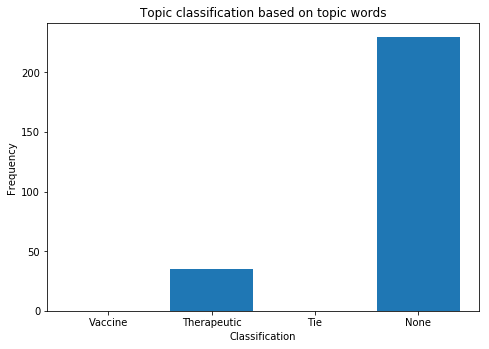

In [37]:
# cord_db

# topic_classification

# abstract_classification
# abstract_vaccines_counter
# abstract_drugs_counter

vaccineFrequency = 0
therapeuticsFrecuency = 0
tieFrequency = 0
noneFrequency = 0

for i in cord_db['topic_classification']:
    if i == 'Vaccine':
        vaccineFrequency += 1
    elif i == 'Therapeutic':
        therapeuticsFrecuency += 1
    elif i == 'Tie':
        tieFrequency += 1
    elif i == 'None':
        noneFrequency += 1

print(vaccineFrequency)
print(therapeuticsFrecuency)
print(tieFrequency)
print(noneFrequency)

topics_list = ['Vaccine','Therapeutic','Tie','None']
frequency_list = [vaccineFrequency, therapeuticsFrecuency, tieFrequency, noneFrequency]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(topics_list,frequency_list)
ax.set_ylabel('Frequency')
ax.set_xlabel('Classification')
ax.set_title('Topic classification based on topic words')
plt.show()

73
162
29
1


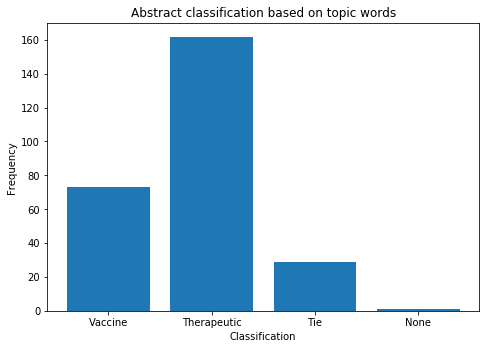

In [38]:
vaccineFrequency = 0
therapeuticsFrecuency = 0
tieFrequency = 0
noneFrequency = 0

for i in cord_db['abstract_classification']:
    if i == 'Vaccine':
        vaccineFrequency += 1
    elif i == 'Therapeutic':
        therapeuticsFrecuency += 1
    elif i == 'Tie':
        tieFrequency += 1
    elif i == 'None':
        noneFrequency += 1

print(vaccineFrequency)
print(therapeuticsFrecuency)
print(tieFrequency)
print(noneFrequency)

topics_list = ['Vaccine','Therapeutic','Tie','None']
frequency_list = [vaccineFrequency, therapeuticsFrecuency, tieFrequency, noneFrequency]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(topics_list,frequency_list)
ax.set_ylabel('Frequency')
ax.set_xlabel('Classification')
ax.set_title('Abstract classification based on topic words')
plt.show()

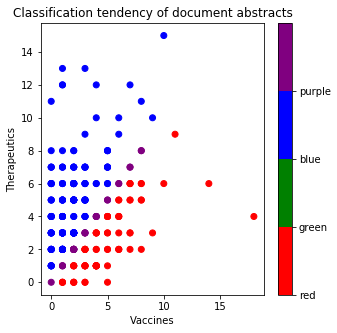

In [39]:
import matplotlib
x = cord_db['abstract_vaccines_counter']
x = x.values.tolist()
y = cord_db['abstract_drugs_counter']
y = y.values.tolist()

#print(x[0])

"""
print(type(x))
print(x)
print(type(y))
print(y)
"""

"""
plt.scatter(x,y)
plt.title("Classification tendency of document abstracts")
plt.xlabel("Vaccines")
plt.ylabel("Therapeutics")
plt.show()
"""

label = []

for i in range(len(x)):
    
    if x[i] > y[i]:
        label.append(0)
    elif x[i] < y[i]:
        label.append(1)
    elif x[i] == y[i]:
        label.append(2)
    elif x[i] == 0 and y[i] == 0:
        label.append(3)
    
    # print(i)


colors = ['red','green','blue','purple']

fig = plt.figure(figsize=(5,5))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("Classification tendency of document abstracts")
plt.xlabel("Vaccines")
plt.ylabel("Therapeutics")
cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)


# abstract_vaccines_counter > abstract_drugs_counter
# abstract_vaccines_counter < abstract_drugs_counter
# abstract_vaccines_counter == abstract_drugs_counter
# abstract_vaccines_counter == 0 and abstract_drugs_counter == 0

265
265
[2, 0, 3, 4, 5, 1]
[0, 1, 2, 3, 4, 5]
{0: {'Vaccine': 13, 'Therapeutic': 36, 'Tie': 7}, 1: {'Therapeutic': 17, 'Vaccine': 8, 'Tie': 2}, 2: {'Vaccine': 10, 'Therapeutic': 19, 'Tie': 4}, 3: {'Therapeutic': 23, 'Vaccine': 7, 'Tie': 5}, 4: {'Vaccine': 25, 'Therapeutic': 44, 'Tie': 9, 'None': 1}, 5: {'Vaccine': 10, 'Therapeutic': 23, 'Tie': 2}}
{0: {'Vaccine': 13, 'Therapeutic': 36, 'Tie': 7}, 1: {'Therapeutic': 17, 'Vaccine': 8, 'Tie': 2}, 2: {'Vaccine': 10, 'Therapeutic': 19, 'Tie': 4}, 3: {'Therapeutic': 23, 'Vaccine': 7, 'Tie': 5}, 4: {'Vaccine': 25, 'Therapeutic': 44, 'Tie': 9, 'None': 1}, 5: {'Vaccine': 10, 'Therapeutic': 23, 'Tie': 2}}
{0: {'Vaccine': 13, 'Therapeutic': 36}, 1: {'Therapeutic': 17, 'Vaccine': 8}, 2: {'Vaccine': 10, 'Therapeutic': 19}, 3: {'Therapeutic': 23, 'Vaccine': 7}, 4: {'Vaccine': 25, 'Therapeutic': 44}, 5: {'Vaccine': 10, 'Therapeutic': 23}}
6
6
6
[0, 1, 2, 3, 4, 5]
[13, 8, 10, 7, 25, 10]
[36, 17, 19, 23, 44, 23]


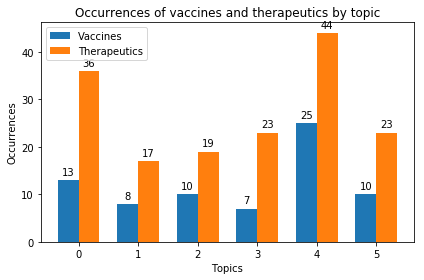

In [40]:
# Gráfica
# x = x.values.tolist()
topics = cord_db['topic']
topics = topics.values.tolist()
classifications = cord_db['abstract_classification']
classifications = classifications.values.tolist()
print(len(topics))
print(len(classifications))

notRepeatedTopics = []
for i in topics:
    if i not in notRepeatedTopics:
        notRepeatedTopics.append(i)
print(notRepeatedTopics)
notRepeatedTopics.sort()
print(notRepeatedTopics)
generalDictionary = {}

for i in notRepeatedTopics:
    generalDictionary[i] = {}

#print(generalDictionary)
for i in range(len(topics)):
    if classifications[i] not in generalDictionary[topics[i]]:
        generalDictionary[topics[i]][classifications[i]] = 1
    else:
        generalDictionary[topics[i]][classifications[i]] += 1

print(generalDictionary)

for i in generalDictionary:
    sorted(generalDictionary[i])

print(generalDictionary)

for i in generalDictionary:
    if 'Tie' in generalDictionary[i]:
        del(generalDictionary[i]['Tie'])
    if 'None' in generalDictionary[i]:
        del(generalDictionary[i]['None'])

print(generalDictionary)

for i in generalDictionary:
    sorted(generalDictionary[i].items())

finalTopicsList = []
finalVaccinesList = []
finalTherapeuticsList = []

for i in generalDictionary:
    finalTopicsList.append(i)
    finalVaccinesList.append(generalDictionary[i]['Vaccine'])
    finalTherapeuticsList.append(generalDictionary[i]['Therapeutic'])

print(len(finalTopicsList))
print(len(finalVaccinesList))
print(len(finalTherapeuticsList))

print(finalTopicsList)
print(finalVaccinesList)
print(finalTherapeuticsList)

#labels = ['G1', 'G2', 'G3', 'G4', 'G5']
#men_means = [20, 34, 30, 35, 27]
#women_means = [25, 32, 34, 20, 25]

x = np.arange(len(finalTopicsList))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, finalVaccinesList, width, label='Vaccines')
rects2 = ax.bar(x + width/2, finalTherapeuticsList, width, label='Therapeutics')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Topics')
ax.set_ylabel('Occurrences')
ax.set_title('Occurrences of vaccines and therapeutics by topic')
ax.set_xticks(x)
ax.set_xticklabels(finalTopicsList)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [41]:
# This function will return the list of file paths of an specific topic
def path_from_topic(topic):
    path_list = []
    cord_topic = cord_db[cord_db.topic == topic]
    for r in range(1,len(cord_topic)):
        sha = cord_topic.iloc[r].sha
        if ';' in sha:
            sha = sha.split(';')[0]
        path_list.append(current_location+cord_topic.iloc[r].full_text_file+'/'+cord_topic.iloc[r].full_text_file+'/'+'pdf_json/'+sha+'.json')
    return path_list

In [42]:
# Read literature documents as JSON
topic_zero = path_from_topic(0)
topic_four = path_from_topic(4)
print(topic_zero)

['CORD-19-research-challenge/custom_license/custom_license/pdf_json/cc6833142021d7b1b0aeb03e102b7fb29269a426.json', 'CORD-19-research-challenge/custom_license/custom_license/pdf_json/27c24bc25e5f22f0771e1fcb3276c728fb446828.json', 'CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/a799d4baa0f252468dcbeaa466fbed7736bf20c5.json', 'CORD-19-research-challenge/custom_license/custom_license/pdf_json/5b626729d78325a28a47be0f1b847ad6925d3473.json', 'CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/5581ec03ebdca073e13b0df6329779940908f038.json', 'CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/3f8beb2781bb92d1e2fffd8361b1feec3fd834e9.json', 'CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/f93195034f642c748faae11cb58300881eb7b2bb.json', 'CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/7e2cac5308e11493311bc4a3e8d15c9b9e7885ad.json', 'CORD-19-research-challenge/custom_license/custom_license/pdf_json/cb

In [43]:
# This function will return the plain text on a specific document
def json_to_text(file):
    title = file['metadata']['title']
    txt = title + "\n"
    if len(file['abstract']) >= 1:
        txt = txt + file['abstract'][0]['text'] + "\n"
    for k in file['body_text']:
        if k['text'] is not None:
            txt = txt + k['text'] + "\n"
    return title, txt

In [44]:
class Data:
  def __init__(self, title, text, label, predicted=None):
    self.title = str(title)
    self.text = str(text)
    self.label = label

In [45]:
# This module read the json files in a topic and tokenize them
# For topic zero considered as Therapeutics label as 0
import json

topic_docs_zero = []

for p in topic_zero:
    print(p)
    with open(p) as f:
        file = json.load(f)
        title, txt = json_to_text(file)
        if title is "":
            title = p
        topic_docs_zero.append(Data(title,txt,0))

CORD-19-research-challenge/custom_license/custom_license/pdf_json/cc6833142021d7b1b0aeb03e102b7fb29269a426.json
CORD-19-research-challenge/custom_license/custom_license/pdf_json/27c24bc25e5f22f0771e1fcb3276c728fb446828.json
CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/a799d4baa0f252468dcbeaa466fbed7736bf20c5.json
CORD-19-research-challenge/custom_license/custom_license/pdf_json/5b626729d78325a28a47be0f1b847ad6925d3473.json
CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/5581ec03ebdca073e13b0df6329779940908f038.json
CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/3f8beb2781bb92d1e2fffd8361b1feec3fd834e9.json
CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/f93195034f642c748faae11cb58300881eb7b2bb.json
CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/7e2cac5308e11493311bc4a3e8d15c9b9e7885ad.json
CORD-19-research-challenge/custom_license/custom_license/pdf_json/cbb9ec2328fdea46172cc0dd7f8f

In [46]:
# This module read the json files in a topic and tokenize them
# For topic zero considered as Vaccines label as 1
import json

topic_docs_four = []

for p in topic_four:
    print(p)
    with open(p) as f:
        file = json.load(f)
        title, txt = json_to_text(file)
        if title is "":
            title = p
        topic_docs_four.append(Data(title,txt,1))

CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pdf_json/70fd2c4e38970a59c42925daef90f674d7b21302.json
CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/7c0e41727a796451e68029e772c970246b71824c.json
CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/1ac9aac4ecdf40363f1377cc08484db3dc4abf93.json
CORD-19-research-challenge/custom_license/custom_license/pdf_json/356e180c8bed920420d2b6c5ad48ba9a4568da31.json
CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/e4ea49d8e5168e27636315e248bad09766c31a2d.json
CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/1e8198cb2eac9d910c4f14712025d90ddb958204.json
CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/95cc317541d97e3dbaa1662894fdbed842098910.json
CORD-19-research-challenge/custom_license/custom_license/pdf_json/983e4e747ad0691e47cb54ed407a014f66f96380.json
CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/5187f0f3f45b0a1882

In [47]:
# Get input text from reduced literature only "Therapeutics and Vaccines"
data = topic_docs_zero + topic_docs_four

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Builds a One-vs-rest model using Logistic Regression with TfidfVectorizer on Threatments and Vaccines literature
def sklearn_ovr_model(data_train, data_validation):
    y_train = [t.label for t in data_train]
    y_test = [v.label for v in data_validation]
    docs_train = [t.text for t in data_train]
    docs_test = [v.text for v in data_validation]

    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(docs_train)
    logisReg = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr').fit(X_train, y_train)
    X_test = vectorizer.transform(docs_test)
    y_hat = logisReg.predict(X_test)
    
    # Updates docs_test prediction
    for i in range(0,len(data_validation)):
        data_validation[i].predicted = y_hat[i]
    
    print("Number of trainning documents: ", len(y_train))
    print("Number of validation documents: ", len(y_test))
    print("Logistic Regression accuracy is: ", accuracy_score(y_test, y_hat))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_hat))
    print("Classification Report:\n", classification_report(y_test, y_hat))
    
    return y_test, y_hat

In [49]:
# This function plots a visual confusion matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

Number of trainning documents:  106
Number of validation documents:  27
Logistic Regression accuracy is:  0.6296296296296297
Confusion Matrix:
 [[ 5  9]
 [ 1 12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.36      0.50        14
           1       0.57      0.92      0.71        13

   micro avg       0.63      0.63      0.63        27
   macro avg       0.70      0.64      0.60        27
weighted avg       0.71      0.63      0.60        27

Normalized confusion matrix
[[0.35714286 0.64285714]
 [0.07692308 0.92307692]]


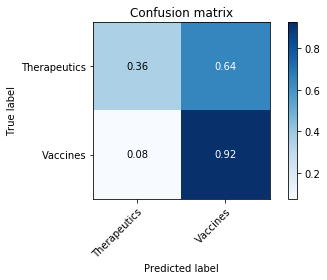

In [50]:
# Plot normalized confusion matrix using sklearn model
data_train, data_validation = train_test_split(data, test_size=0.2)
y_test, y_hat = sklearn_ovr_model(data_train, data_validation)
plot_confusion_matrix(y_test, y_hat, classes=["Therapeutics","Vaccines"], normalize=True,
                      title='Confusion matrix')

plt.show()

In [51]:
# Print results of classification according to title
from tabulate import tabulate

lst_row = [[x.title, x.label, x.predicted] for x in data_validation]

print(tabulate(lst_row, headers=['Title', 'Label', 'Predicted'], showindex=range(0,len(data_validation)), tablefmt='grid'))

+----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-------------+
|    | Title                                                                                                                                                                                                                                            |   Label |   Predicted |
+====+==================================================================================================================================================================================================================================================+=========+=============+
|  0 | Clinical predictors of mortality of Middle East Respiratory Syndrome Coronavirus (MERS-CoV) infection: A cohort study                                                      

In [52]:
# Print acccuracy from Cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
docs = [t.text for t in data]
y = [v.label for v in data]
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr')),
])
scores = cross_val_score(pipeline, docs, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.14)
